# Prediction
Purpose: I would like to better understand the retinal predictive properties described by Stepahnie Palmer in her paper,
> Palmer, S. E., Marre, O., Berry, M. J., & Bialek, W. (2015). "Predictive information in a sensory population." *Proceedings of the National Academy of Sciences of the United States of America*, 112(22), 6908–6913. https://doi.org/10.1073/pnas.1506855112

This notebook also uses [nengo](http://nengo.ai).

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot

# These next lines allow you to run nengo_gui within jupyter.
#from nengo_gui.ipython import IPythonViz
#IPythonViz(model)

In [39]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
np.set_printoptions(edgeitems=30, linewidth=250, precision=4)

## Stimulus: `WanderingBar`

In [40]:
class WanderingBar(nengo.Process):
    def __init__(self, Gamma=20., w=4.2, **kwargs):
        self.x = np.array([0., 0])
        self.Gamma = Gamma
        self.w = w
        self.D = 2.7e6
        # pass the default sizes to the Process constructor
        super(WanderingBar, self).__init__(default_size_in=0, default_size_out=2, **kwargs)
        
    def make_step(self, shape_in, shape_out, dt, rng, xv=None):
        
        def step(t):
            x,v = self.x
            dxdt = v
            dvdt = -self.Gamma*v - self.w**2*x
            
            self.x[0] += dt*dxdt
            self.x[1] += dt*dvdt + np.random.normal()*np.sqrt(self.D*dt)
            return self.x
        
        return step

## Nengo network

Create a Nengo network. This one createsd a "Node" b that simply spits out the location (and velocity) of the wandering bar. The location output (ie. b[0]) gets fed into an "Ensemble" A, which is a population of spiking neurons.

In [62]:
with nengo.Network() as model:
    b = nengo.Node(WanderingBar(), size_in=0, size_out=2)
    b_p = nengo.Probe(b)
    
    A = nengo.Ensemble(n_neurons=50, radius=200, dimensions=1)
    
    nengo.Connection(b[0], A)
    A_p = nengo.Probe(A.neurons)

Run the simulation for some time.

In [63]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Plot the wandering bar location. We have access to that from the Probe we created.

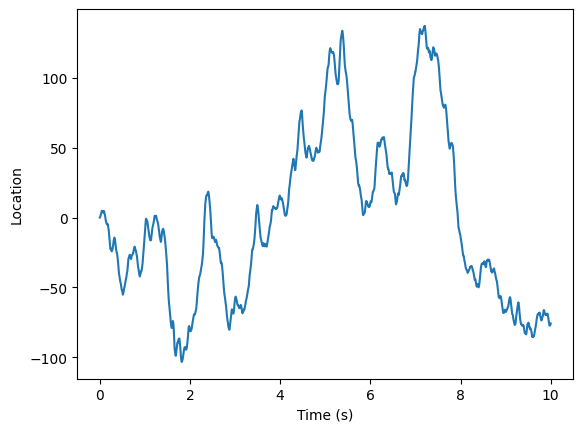

In [59]:
plt.plot(sim.trange(), sim.data[b_p][:,0]);
plt.ylabel('Location'); plt.xlabel('Time (s)');

## Neuon activity

We added a probe to the neurons in the ensemble A. We can see what each neuron's output was.

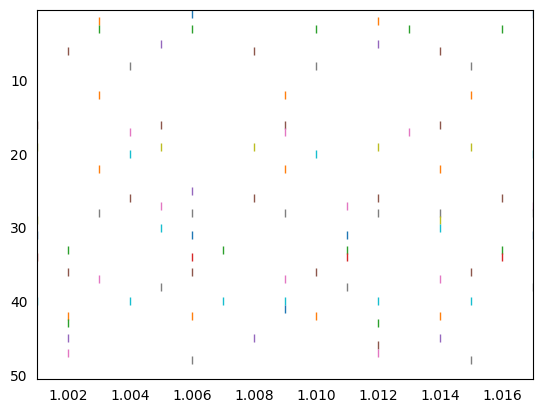

In [65]:
# Let's plot the spikes from 1 second to 1.017 seconds.
rasterplot(sim.trange()[1000:1017], sim.data[A_p][1000:1017]);

Now let's extract which neurons spiked during a 17ms interval.

In [66]:
def activity(sp, t):
    '''
     w = activity(sp, t)
     
     It looks at the neuron output stored in sp and determines which
     neurons spiked at least once during the time interval (t, t+17ms).
     The output is a binary vector.
    '''
    k0 = int(1000*t)
    w = np.array( np.sum( sim.data[A_p][k:k+17,:], axis=0 ) > 0 , dtype=int)
    return w

In [67]:
activity(sim.data[A_p], 1.7)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0])